### MNIST Multiclass classifier

In [ ]:
!pip install torch torchvision matplotlib tqdm

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm


In [11]:

# Define transformations to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Set the number of samples for the subset
subset_size = 1000

# Select random 1000 samples for both training and testing
train_subset = Subset(train_dataset, torch.randperm(len(train_dataset))[:subset_size])
test_subset = Subset(test_dataset, torch.randperm(len(test_dataset))[:subset_size])

# Create DataLoaders for training and testing from the same subset
train_loader_subset = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader_subset = DataLoader(test_subset, batch_size=64, shuffle=False)


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Define the CNN layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Fully connected layer after flattening the feature maps
        self.fc2 = nn.Linear(512, 10)  # Output layer (10 classes for MNIST)

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate the model
model = CNN()


In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


Epoch [1/5]: 100%|██████████| 16/16 [00:01<00:00,  9.80batch/s]


Epoch [1/5], Loss: 3.5105, Accuracy: 0.5250


Epoch [2/5]: 100%|██████████| 16/16 [00:02<00:00,  6.95batch/s]


Epoch [2/5], Loss: 0.4865, Accuracy: 0.8480


Epoch [3/5]: 100%|██████████| 16/16 [00:01<00:00,  9.19batch/s]


Epoch [3/5], Loss: 0.3154, Accuracy: 0.9030


Epoch [4/5]: 100%|██████████| 16/16 [00:01<00:00, 10.13batch/s]


Epoch [4/5], Loss: 0.1804, Accuracy: 0.9330


Epoch [5/5]: 100%|██████████| 16/16 [00:01<00:00, 10.07batch/s]


Epoch [5/5], Loss: 0.1595, Accuracy: 0.9510


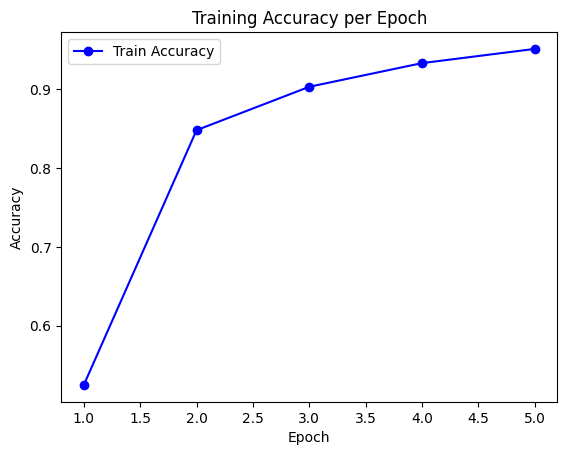

In [22]:

# Training loop with tqdm for progress bar
num_epochs = 5
train_accuracies = []  # List to store accuracy per epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Wrap the DataLoader with tqdm for progress bar
    for images, labels in tqdm(train_loader_subset, desc=f'Epoch [{epoch+1}/{num_epochs}]', unit='batch'):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate accuracy for this epoch
    epoch_accuracy = correct_predictions / total_predictions
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_subset):.4f}, Accuracy: {epoch_accuracy:.4f}')

# Plot accuracy per epoch
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='b', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.show()


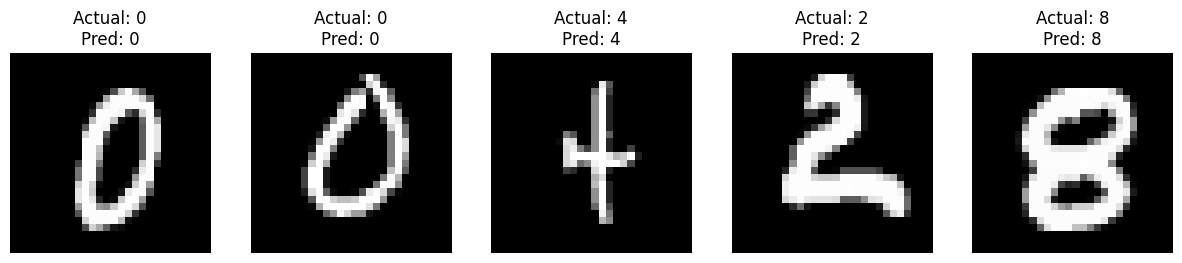

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test subset
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader_subset:
        # Forward pass
        outputs = model(images)

        # Get predictions
        _, preds = torch.max(outputs, 1)

        # Store true labels and predictions
        true_labels.extend(labels.numpy())
        predicted_labels.extend(preds.numpy())

# Plot a few predictions (Actual vs Predicted)
num_samples = 5  # Number of samples to display
images_to_show = []

# Get a batch of test images
images, labels = next(iter(test_loader_subset))

# Get predictions for the batch
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Collect images for display
images_to_show = images[:num_samples]
true_labels_display = labels[:num_samples]
predicted_labels_display = preds[:num_samples]

# Plot the images along with actual and predicted labels
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(images_to_show[i].squeeze(), cmap='gray')
    ax.set_title(f"Actual: {true_labels_display[i]}\nPred: {predicted_labels_display[i]}")
    ax.axis('off')

plt.show()


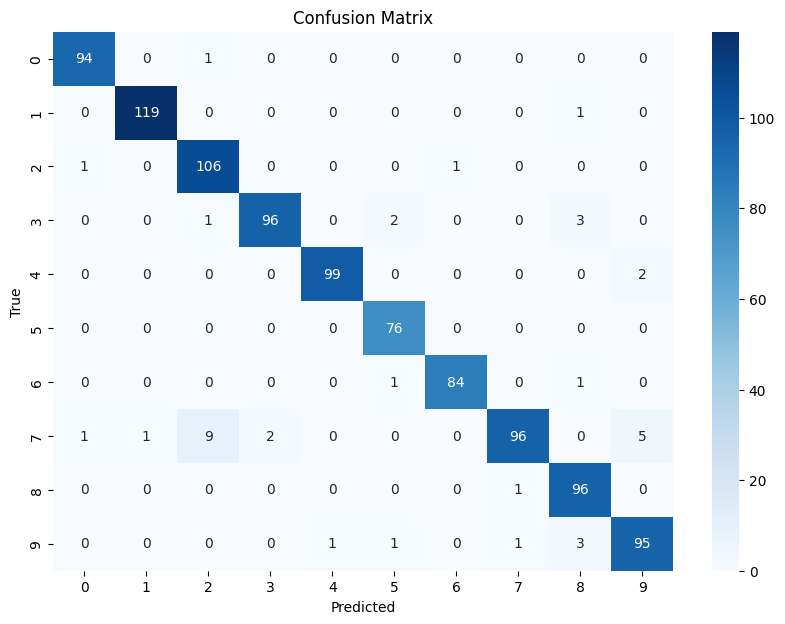

In [19]:

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
